# **Deep Learning Homework 6: *Variational Autoencoders***
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering

---

In this homework, we will explore how to develop a Variational Autoencoder (VAE) using the MNIST dataset. In developing the VAE we also explore how to develop an ad-hoc layer and a custom training step.

### Load Dataset
We load the MNIST dataset, using `tf.keras.datasets`. The dataset contains 60,000 training grayscale images and 10,000 testing image of handwritten digits.

In [1]:
# load necessary libriaries and functions
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.subplot(1, 2, 1)
  plt.plot(history.epoch,history.history['reconstruction_loss'])
  plt.title('reconstruction_loss')
  plt.subplot(1, 2, 2)
  plt.plot(history.epoch,history.history['kl_loss'])
  plt.title('kl_loss')
  plt.show()

In [2]:
(x_train_full, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the pixel values
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Flatten the arrays
x_train = x_train_full.reshape((len(x_train_full), np.prod(x_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# In this HW, we will not need a validation set since we will not deal with model selection
# x_valid, y_valid = x_train[:10000], y_train[:10000]
# x_train, y_train = x_train[10000:], y_train[10000:]

11501568/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 6.1: Variational Autoencoder: reparameterization trick
To implement a VAE we have to define 2 main parts: the _Encoder_ and the _Decoder_.
Let's start by the Encoder, that computes an encoding of the input from which it computes the mean and the average of the sample distribution.
Once we have these two statistics, we have to implement the sampling phase. Keras does not provide any predefined method to perform this operation, therefore we have to define it. With the aim to be consistent with the layer-composition paradigm used by Keras in defining a model, we define a Sampling layer as a new layer.

To do this we define a new class that inherits from the layer base class `tf.keras.layers` that is used as base class for all the layers defined in Keras. In more detail, from this class we are interested in overriding the *call* method, that is the one that is called when a layer is exploited by the model, and where the operations executed by the layer are defined.

In our case, the Sampling layer has in input the tuple made of the mean and the log-variance, and it has to compute the sample $z$ from them by exploiting the reparameterization trick:
$$
z=z_{mean} + exp(z_{var}/2) * \epsilon
$$
The reparameterization trick is used in VAE because it actually helps in the backpropagation process. Specifically, $\epsilon \sim \mathcal{N}(0,1)$ actually reparameterizes our VAE network. This allows the mean and log-variance vectors to still remain as the learnable parameters of the network while  maintaining the stochasticity of the entire system via epsilon.

**[TO COMPLETE]**: complete the code defining the Sampling layer that implements the reparametrization trick.

**Hint**: to generate random values from a normal distribution you can use the keras [tf.keras.backend.random_normal](https://www.tensorflow.org/api_docs/python/tf/keras/backend/random_normal) method, and make sure the output shape is the proper one.


In [3]:
class Sampling(tf.keras.layers.Layer):
   
    def call(self, inputs):
        #[TO COMPLETE] compute and return z
        z_mean, z_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_var*0.5) * epsilon

##[TO COMPLETE] Exercise 6.2: Encoder
Now we can define the Encoder. Let's use $n$ dense layers (similarly to what we did in HW5, with a funnel-like architecture), and then use the obtained encoding to compute `z_mean` and `z_var`, by using two different dense layers. Finally, we use the Sampling layer to compute the sample $z$. Note that we define the `latent_dim` (that is the dimension of $z$) to $2$. This choice is made to make possible to represent the results graphically.

**[TO COMPLETE]**: complete the code defining a deep encoder and the Dense layers that model `z_mean` and `z_var`. Explain your choice for what concerns the number of layers, the layers sizes and the activation functions. Insert motivations about your choice into the tex cell below.

In [4]:
latent_dim = 2
INPUT_DIM = x_train.shape[-1]

encoder_inputs = tf.keras.layers.Input(shape=(INPUT_DIM,))
#x = #[TO COMPLETE]
# x = ...[TO COMPLETE with more layers]...
x = tf.keras.layers.Dense(256, activation="relu")(encoder_inputs)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x) #[TO COMPLETE] Hint: size would be = latent_dim
z_var =  tf.keras.layers.Dense(latent_dim, name="z_var")(x)#[TO COMPLETE] Hint: size would be = latent_dim
z = Sampling()([z_mean, z_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          32896       ['dense_1[0][0]']                
                                                                                            

**Answer:** [TO COMPLETE]

I have initially decided to use 2 hidden layers besides the input and output layers to define the encoder. Since it's initially difficult to accurately gauge the complexity of the problem, and the data set is relatively large - consisting of tens of thousands of images, I considered that using 2 hidden layers would be more appropriate than a basic 3 layer encoder. 
Regarding the number of neurons, I chose these values as a basis to account for the perceived model complexity. 
The activation funciton used was 'relu' since it is a common/ recommended default acitivation function regarding neural networks, especially those with multiple layers which is the case here. 

##[TO COMPLETE] Exercise 6.3: Decoder
Then we have to define the decoder part. It takes in input $z$ that "decodes" as an image in the input space. The architecture of the decoder should be specular to the encoder architecture, i.e. $n$ layers of the same dimensions of ones in the encoder, but occurring in the reverse order.

**[TO COMPLETE]**: Define the decoder. Explain in this cell your choice for what concerns the number of layers, the layers sizes, and the activation functions (in particular, for what concerns the last layer). Answer in the text cell below.

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
#x = [TO COMPLETE]

x = tf.keras.layers.Dense(128, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)

decoder_outputs = tf.keras.layers.Dense(INPUT_DIM,activation="sigmoid")(x) #[TO COMPLETE]

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 128)               384       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 784)               201488    
                                                                 
Total params: 251,408
Trainable params: 251,408
Non-trainable params: 0
_________________________________________________________________


**Answer:** [TO COMPLETE]
The reasons for choosing the number and size of the layers is equivalent to what was outlined in 6.2 for the encoder, to ensure specularity. Regarding the activation function, sigmoid was deemed most appropriate since the output for this task is of a binary nature. Since signmoid outputs probabilites between 0 and 1, for inputs belonging to a specific class, it is best suited to this task since we are using the MNIST data set to predict/produce outcomes based on probabilities, which only exist between 0 and 1.

##[TO COMPLETE] Exercise 6.4: Training
Now we can define the VAE, but since it is a generative model, we have to define an ad-hoc training phase. Specifically, we have to manage the two losses used for this model. Indeed the parameters of a VAE are trained via two loss functions: a reconstruction loss, that forces the decoded samples to match the initial inputs, and a regularization loss that helps to learn  a well-formed latent space, and to reduce overfitting. The regularization loss is handled with the Kullback-Liebler Divergence. While for the reconstruction loss we are supposed to use the negative log-likelihood. Keras, however, does not support it natively, so to make the exercise simple, we will use as a proxy the binary cross-entropy (`keras.losses.binary_crossentropy`) to compare each feature of a data point to the value in the reconstructed output.

Therefore, we have to define a class that inherits from [keras.model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), and overrides the [training_step method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#train_step), that allows to define a custom training logic.

**[TO COMPLETE]** implement the reconstruction loss and the KL-loss.

In [6]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # record operations for automatic differentiation
            z_mean, z_var, z = encoder(data)
            reconstruction = decoder(z)


            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction)))
            kl_loss = -0.5 * (1 + z_var - tf.square(z_mean) - tf.exp(z_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # optimize the custom loss
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

Let's now train the VAE model using Adam as optimizer.

Epoch 1/30
469/469 [==============================] - 5s 4ms/step - loss: 34.3313 - reconstruction_loss: 33.3966 - kl_loss: 0.9347
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 30.9727 - reconstruction_loss: 29.2317 - kl_loss: 1.7410
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 29.7610 - reconstruction_loss: 27.2511 - kl_loss: 2.5099
Epoch 4/30
469/469 [==============================] - 2s 4ms/step - loss: 29.1566 - reconstruction_loss: 26.2509 - kl_loss: 2.9057
Epoch 5/30
469/469 [==============================] - 2s 4ms/step - loss: 28.7994 - reconstruction_loss: 25.6870 - kl_loss: 3.1123
Epoch 6/30
469/469 [==============================] - 2s 4ms/step - loss: 28.6049 - reconstruction_loss: 25.3581 - kl_loss: 3.2468
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 28.4384 - reconstruction_loss: 25.0905 - kl_loss: 3.3480
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 28.3293 -

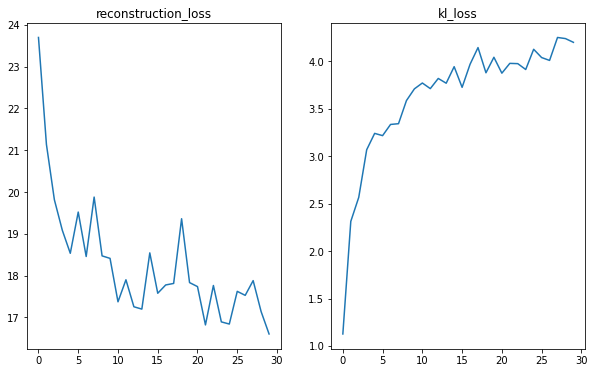

In [7]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=128)
plot_loss(history)

##[TO COMPLETE] Exercise 6.5: Model Analysis
Now we can plot an example of the data generation by using the decoder part. Since we used a 2D latent space let's generate sevral possibile 2D $\hat{z}$ samples and pass them to our decoder. With the $scale$ parameter we can define the interval from where the entries of $\hat{z}$ are chosen, and with parameter $n$ it is possibile to define how many samples are generated.  

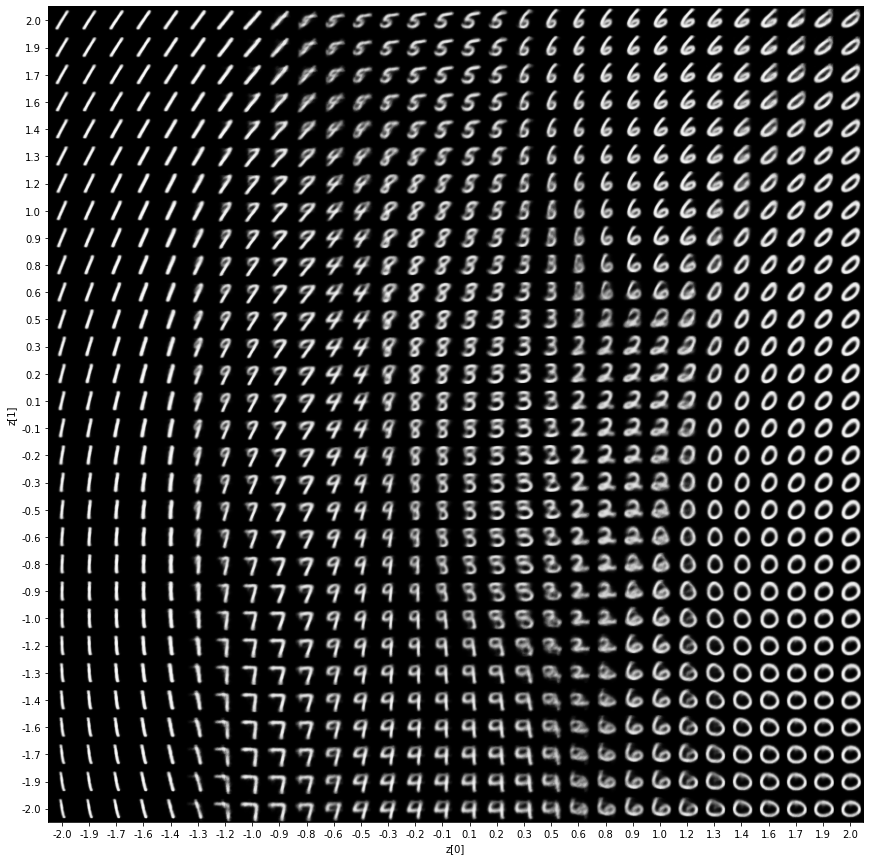

In [8]:
def plot_latent(encoder, decoder, scale=2.0, n = 30):
     
    digit_size = 28
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder, 2.0, 30) 

#[TO COMPLETE] explore what happens with different "scales"

The final result is quite impressive, considering that all these digits are artificial and they not belong to any dataset!
Let's finally check how the various digits have been represented in the latent space by the VAE.

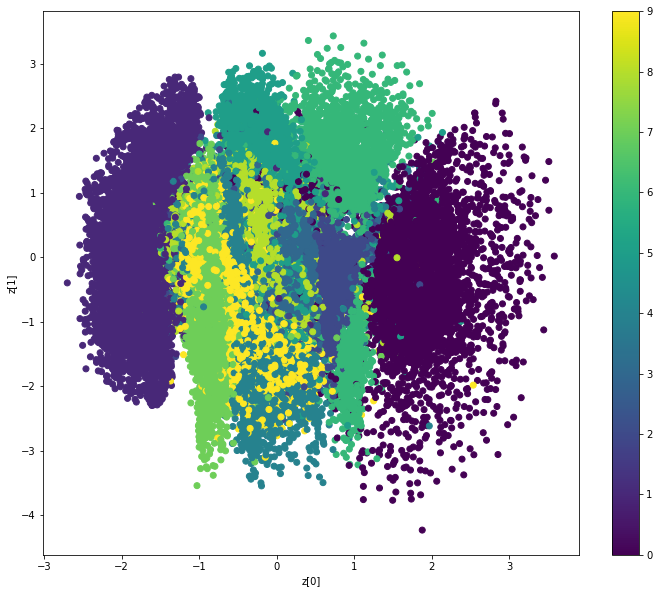

In [9]:
def plot_label_clusters(encoder, decoder, data, labels):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

plot_label_clusters(encoder, decoder, x_train, y_train)

**[TO COMPLETE]** Discuss the obtained plots, and  explore how the hyper-parameters of the VAE (number of layers, layer sizes, etc.) influence the final result. Insert your discussion into cells immediately below this one.

**Answer:** [TO COMPLETE}

Regarding exploring different scales the following were tested: 0.5,1,2,3,4 and 5. 

The 'plot_latent' figure is more accurate with a smaller scale. As the scale increases the figure is more difficult to interpret, the numbers are blurry and the more 'rounded' numbers such as 6,8 and 9 are more difficult to compute. The converse is true for using a smaller scale, however the plot is still not completely in focus and a little blurry in some areas. In each case not all numbers 0-9 are visible in the plot, usually arounf 3-5 numbers. The difference in numbers that were able to be computed well were shown in the cluster plots - the orientation of the clusters changed but the separation between the clusters did not change too drastically as the scale increased. A smaller scale outputted clusters that showed more distinct separation with regards to the more rounded numbers, in all plots the numbers 5-9 showed the most overlap. 

Exploring the hyperparamters of the VAE

Layer numbers

Removing a Layer: using a 3 layer network, the model performance is slightly worse than using 4 layers: there are more numbers that are not eligible in the 'plot_latent' figure when compared to using a network with 2 hidden layers. The cluster plot is slighltly similar to the 4 layer network in terms of the cluster separation, but differs with respect to the types of numbers that are identifiable. The cluster plot for the 4 layer network is better at distinguishing between the numbers 8 and 9 but the 3 layer network is not (clusters are not as separated in 3 layer plot). Thus the 3 layer network is worse at determining 'rounded' numbers. 

Adding a layer: Using a 5 layer network shows a similar performance of the model when compared with the 4 layer network, as the cluster plot shows distinguished and well separated clusters. This as well as the 'plot_latent' figure, also conveys difficulty in identifying 'rounded' numbers, in particular 9 and 8, as well as numbers 5 and 7. So the performance between this and the original model is about the same overall - with both models being able to best identify a different range of numbers - with the 4 layer network being the most robust with computing 'rounded' numbers. 

Layer sizes

Size reduction by 0.5:This seemes to slightly worsen the model's performance. The 'plot_latent' figure has a bit more blurry, indistinguishable variables, which is also conveyed in the cluster plot - 0,6 and 7 are the most identifiable numbers. All other clusters that represent the other numbers have  more overlap when compared with the original model, with 5-9 being hardest to identify. 

Size increase by 0.5:This shows an improvement in the models performance. The majoirty of the variables in the 'plot_latent' figure are easier to distinguish where the 'rounded' numbers 8 and 9 are identified noticably better. Numbers 7-9 are again amongst the harderst numbers to compute. 

So it seems that the layer size has a stronger influence in improving the model's performance and dealing with the model complexity when compared to the number of layers.

output activiation function: using the softmax activation function significantly worsened the model performance to the point where almost all of the numbers in the 'plot_latent' figure were not identifiable. This could mainly be due to the lack of suitablity to the task and thus strongly justifies the use of the sigmoid activation function. 

Hidden layer activation functions:

Tanh: using tanh for the hidden layers produced worse results with the clusters showing considereable overlap and difficult to identify between the numbers. The plot_latent figure demonstrated a higher concentration of numbers that were unidentifiable when compared to the use of the relu function and overall, the model was only able to compute a very limited number of values.

LeakyRelu: This model produced very similar results to the original model which are almost undistiguishable. There are a few numbers that are not computed well in the plot latent figure which means that the relu function was the most suitable for this task. 

Regarding the plots for the reconstruction and KL regularisation loss, across all parameter adjustments, the differences where quite negligible except for the use of the softmax and leaky relu function and using 1 less layer. This suggests that these parameters have a strong influence over the model's accuraccy/ performance and shows that these parameter adjustments do not output a good model.This also helped to  justify the use of the relu function over the leaky relu function whose 'plot_latent' and cluster figures were quite similar. 
